### **Ohad Cohen**

**Overview**

This notebook presents the submission for the Workout Video Classification task. Over the past week, I have experimented with various approaches to tackle this challenge. 

These experiments involved testing different hyperparameters across three models and using some data augmentation techniques to enrich the dataset. 

The models were trained on the provided dataset, which was split into training set, validation set and test set. Initially, these experiments were conducted using separate .py scripts outside of the notebook environment, using a NVIDIA A100 GPU for training.

In [1]:
import glob
import os
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchmultimodal.transforms.video_transform import VideoTransform
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from early_stopping_pytorch import EarlyStopping
from torch import optim
from torchinfo import summary
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
VIDEO_PATH = '/home/dsi/ohadico97/homework/data' # change to your data path
MP4_FILES = glob.glob(os.path.join(VIDEO_PATH, '**', '*.mp4'), recursive=True)
len(MP4_FILES)

590

In [5]:
class GymDataset(Dataset):
    def __init__(self, path_list, target_frames=16, image_size=180, augment=False):
        self.video_paths = path_list
        self.augment = augment
        self.vt = VideoTransform()
        self.vt.time_samples = target_frames 
        self.vt.resize_shape = (image_size,image_size)
        
        self.CLASS_LABELS = {
            "barbell biceps curl": 0,
            "bench press": 1,
            "chest fly machine": 2,
            "deadlift": 3,
            "decline bench press": 4,
            "hammer curl": 5,
            "hip thrust": 6,
            "incline bench press": 7,
            "lat pulldown": 8,
            "lateral raise": 9,
            "leg extension": 10,
            "leg raises": 11,
            "plank": 12,
            "pull Up": 13,
            "push-up": 14,
            "romanian deadlift": 15,
            "russian twist": 16,
            "shoulder press": 17,
            "squat": 18,
            "t bar row": 19,
            "tricep dips": 20,
            "tricep Pushdown": 21
        }
        
        if self.augment:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.RandomApply([
                    T.RandomRotation(degrees=(-30,30))
                ], p=0.80),
                T.RandomHorizontalFlip(p=0.4),
                T.RandomVerticalFlip(p=0.4),
                T.ToTensor()
            ])
        else:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.ToTensor()

            ])
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.CLASS_LABELS[os.path.basename(os.path.dirname(video_path))]
        
        video, _, _ = torchvision.io.read_video(video_path,pts_unit='sec')
        video = self.vt(video.unsqueeze(0))
        video = video.squeeze(0)
        video = video.permute(1, 0, 2, 3)  # T, C, H, W
        
        return video.permute(1,0,2,3), label 

Cell for debug GymDataset. __getitem__ returns frames's shpae of:[num_channels, frames, H,W] --> [3,16,180,180] and the label of that sample. I sample 16 RGB frames from a video clip.

In [6]:
w = GymDataset(MP4_FILES,augment = True).__getitem__(50)
f,l = w
f.shape,l

(torch.Size([3, 16, 180, 180]), 1)

Checking the input for the models:

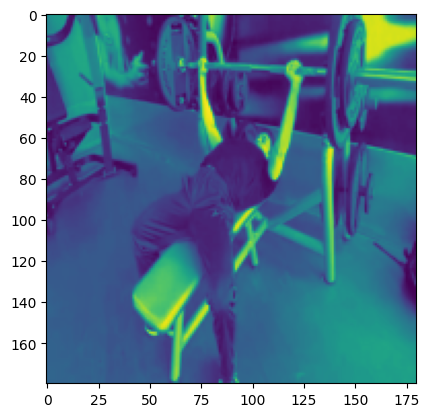

In [7]:
plt.imshow(f[0,0,:,:])


First, a fully connected classification layer was defined as the model "head," mapping output features to class predictions. It consists of a linear layer (linear1), followed by ReLU, another linear layer (linear2), and a final output for class prediction. Each model connected to this head.

In [19]:
class ClassificationLayer(nn.Module):
    def __init__(self, num_feat=768, n_classes=8):
        super(ClassificationLayer, self).__init__()

        self.linear1 = nn.Linear(num_feat, num_feat)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(num_feat, n_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

I defined my own custom 3DCNN, this model will be train from scratch:

In [28]:
class CNNClassifayer(nn.Module):
    def __init__(self,num_c = 22):
        super(CNNClassifayer, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(3, 128, kernel_size=3, padding='same'),
                                   nn.BatchNorm3d(128),
                                   nn.ReLU(),
                                   nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))) #C,H,W
                                   
        self.conv2 = nn.Sequential(nn.Conv3d(128, 256, kernel_size=3, padding='same'),
                                   nn.BatchNorm3d(256),
                                   nn.ReLU(),
                                   nn.Dropout3d(0.25),
                                   nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2)))
                                   
        self.conv3 = nn.Sequential(nn.Conv3d(256, 256, kernel_size=3,  padding='same'),
                                   nn.BatchNorm3d(256),
                                   nn.ReLU(),
                                   nn.Dropout3d(0.25),
                                   nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))) 
                 
        self.classifier = ClassificationLayer(num_feat=256,n_classes=num_c)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.adaptive_avg_pool3d(x, (1,1,1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Since training from scratch did not gave the best accuracy, I fine-tuned two known models:
1) "[X3D: Expanding Architectures for Efficient Video Recognition](https://research.facebook.com/publications/x3d-expanding-architectures-for-efficient-video-recognition/)" From Facebook AI Research. I used the X3D-S which is a lightweight efficient 3D convolutional neural network designed for video classification. The model decomposes the architecture along four expansion factors: Temporal, Spatial, Width and Depth.

2) "[R(2+1)D](https://arxiv.org/pdf/1711.11248v3)" - an 18-layer ResNet-based architecture designed for action recognition. The model decomposes the 3D convolutions into separate spatial (2D) and temporal (1D) convolutions, which allows it to effectively capture both spatial and temporal features in the video data.

Both models gave high accuracy score.

In [10]:
class VideoModel(nn.Module):
    def __init__(self, model_name='x3d_s',num_classes = 22,output_features=512):
        super(VideoModel, self).__init__()
        if model_name is not None:
            model_name = 'x3d_s'
            self.model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)
            self.model.blocks[5].activation = nn.Identity() # .ModuleList
            self.model.blocks[5].proj = nn.Linear(in_features=self.model.blocks[5].proj.in_features, out_features=output_features)# 512
        else:
            self.model = models.video.r2plus1d_18(pretrained=True)
            self.model.fc = nn.Sequential(nn.Dropout(0.4),#0.1
                                            nn.Linear(in_features=self.model.fc.in_features, out_features=output_features))# 512
        self.modes = ["clip"]
        self.classifier = ClassificationLayer(num_feat=output_features,n_classes=num_classes)
    def forward(self, x):
        out = self.model(x)
        out = self.classifier(out)
        return out

In [ ]:
def prep_data(BATCH_SIZE=32):
    
    train_files, temp_files = train_test_split(MP4_FILES, test_size=100, random_state=RANDOM_SEED) # 100 samples out from train to val-test splits  --> 50 for val and 50 for test
    val_files, test_files = train_test_split(temp_files, test_size=50, random_state=RANDOM_SEED)

    train_dataset = GymDataset(train_files, augment=True)
    val_dataset = GymDataset(val_files, augment=False)
    test_dataset = GymDataset( test_files, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers = 16,pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers = 16,pin_memory=True,persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False,num_workers = 16,pin_memory=True,persistent_workers=True)

    return train_loader,val_loader,test_loader

In [12]:
def train_model(model, data_loader, optimizer,criterion,device):
    """
    Train the model.
    
    Args:
        model: PyTorch model.
        dataloader: Training data DataLoader.
        device: CUDA or CPU.
    """
    model.train()
    total_loss = 0
    
    for batch in data_loader:
        x,y = batch
        inputs = x.to(device)
        targets = y.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
            
        loss = criterion(outputs, targets)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    return total_loss / len(data_loader)

In [13]:
def validate(model, data_loader, criterion,device):
    """
    Runs validation.
    
    Args:
        model: Trained PyTorch model.
        dataloader: Validation data DataLoader.
        device: CUDA or CPU.
    """
    total_loss = 0
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)  
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(targets.cpu().tolist())
    print("Val Accuracy: ",accuracy_score(actual_labels, predictions))

    return  total_loss / len(data_loader)

In [14]:
def test(model, data_loader,device):
    """
    Test the model.
    
    Args:
        model: Trained PyTorch model.
        dataloader: Testing data DataLoader.
        device: CUDA or CPU.
    """

    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)  
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(targets.cpu().tolist())

    print("Test Accuracy: ",accuracy_score(actual_labels, predictions))

In [ ]:
def main(model_name):
    
    if model_name == 'None':
        print("Fine-tuning with R(2+1)D")
        BATCH_SIZE = 32
        LR = 0.0001
        es_patience = 5
        model = VideoModel(model_name=None) # None is for R(2+1)D
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5) 
    elif model_name == 'x3d_s':
        print("Fine-tuning with X3D_S")
        BATCH_SIZE = 64
        LR = 0.0001
        es_patience = 5
        model = VideoModel(model_name=model_name)
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5)
    elif model_name == '3DCNN':
        print("Training with custom CNN")
        BATCH_SIZE = 16
        LR = 0.001
        es_patience = 20
        model = CNNClassifayer()
        optimizer = optim.Adam(model.parameters())


    EPOCHS = 500
    TRAINED_MODEL_PATH = f"/home/dsi/ohadico97/homework/trained_{model_name}_{LR}_{BATCH_SIZE}.pth"

    model.to(device)
    train_data_l,val_data_l,test_data_l = prep_data(BATCH_SIZE)

    criterion = nn.CrossEntropyLoss()

    early_stopping = EarlyStopping(patience=es_patience, verbose=True,path=f"/home/dsi/ohadico97/homework/checkpoint_{model_name}_{LR}_{BATCH_SIZE}.pth")
    # print(summary(model, input_size=(BATCH_SIZE,1, 16, 180, 180)))
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_loss = train_model(model, train_data_l, optimizer,criterion, device)
       
        val_loss = validate(model, val_data_l, criterion, device)

        print(f'train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
    torch.save(model.state_dict(), TRAINED_MODEL_PATH)

    test(model,test_data_l,device)


To run training and testing (both in a single run), choose which model you want to train:

*model_name=* "3DCNN" -> Custom 3D CNN, training from scratch.

*model_name=* "x3d_s" -> Pre-trained Facebook FAIR for fine-tuning.  

*model_name=* "None" -> Pre-trained R(2+1)D for fine-tuining.

In [ ]:
model_name = "x3d_s" # "3DCNN" | "None" | "x3d_s"
main(model_name)

To test only the model (after training - optional).

In [35]:
model_name = "x3d_s" # "3DCNN" | "None" | "x3d_s"
_,_,test_data_l = prep_data()

if model_name == "None": #R(2+1)D
    model = VideoModel(model_name=None)
    model_path = "/home/dsi/ohadico97/homework/models/r21d/trained_None_0.0001_32_with_aug_86%.pth"
elif model_name == "x3d_s":
    model = VideoModel(model_name=model_name) 
    model_path = "/home/dsi/ohadico97/homework/models/xd3_s/checkpoint_x3d_s_0.0001_64_with_aug_92%.pth"
elif model_name == "3DCNN":
    model = CNNClassifayer()
    model_path = "/home/dsi/ohadico97/homework/models/cnn/trained_3DCNN_0.001_16_68%.pth"

model.load_state_dict(torch.load(model_path))
model.to(device)
test(model,test_data_l,device)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


Test Accuracy:  0.92


### Results:
1) X3D_S - 92% Accuracy on test set.

2) R(2+1)D - 84% Accuracy on test set.

3) Custom 3DCNN - 68% Accuracy on test set.